<a href="https://www.kaggle.com/code/marinabalakina/dll30-dz10?scriptVersionId=158338770" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

В работе использован датасет из ноутбука kaggle https://www.kaggle.com/code/konstantinazov/hwcw1-1?rvi=1, аналогичный https://github.com/Shenggan/BCCD_Dataset

In [14]:
import numpy as np 
from math import sqrt
import pandas as pd
import time
import os

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision as tv

# from torchvision.models.detection import ssd300_vgg16

from torchvision.models.detection import ssdlite320_mobilenet_v3_large

import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data


In [15]:
import warnings
warnings.filterwarning='ignore'

### Setting

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

np.random.seed(21)
torch.manual_seed(21);
# Образцы для проверки работы модели
test = [0,2,14,17,28,29,30]

### Dataset

In [17]:
class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root='/kaggle/input/bccd-dataset/', trans=None):
        super()
        self.root = root
        # данные, подготовленные с помощью скрипта export.py
        self.pds = pd.read_csv(os.path.join(root,"test.csv"))
        self.classes = ['Background'] + list(self.pds.cell_type.unique())
        self.classes_idx = {w: i for i, w in enumerate(self.classes)}
        self.transforms = tv.transforms.Compose([
#                tv.transforms.Resize([300, 300]),
                # выбранная модель работает с картинками 320*320
#                 tv.transforms.Resize([320, 320]),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ])
        self.imgs = self.pds.filename.unique()
        
    def get_image(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        return img
    
    def __getitem__(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        x = self.pds
        x = x[x.filename == filename]
        x = x[x.xmin < x.xmax]
        x = x[x.ymin < x.ymax]
        x = np.array(x)
        for i in range(len(x)):
            x[i,1]=self.classes_idx[x[i,1]]
        labels  = torch.as_tensor(x[:,1].astype(int), dtype=torch.int64).to(device)
        boxes = torch.as_tensor(x[:,[2,4,3,5]].astype(float), dtype=torch.float32).to(device)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(x),), dtype=torch.int64)


        img = self.transforms(img).to(device)

        return img, {'boxes':boxes, 'labels':labels}

    def __len__(self):
        return len(self.imgs)

### Model & Dataset

In [18]:
# model = ssd300_vgg16(pretrained = True).to(device)
model = ssdlite320_mobilenet_v3_large(pretrained = True).to(device)
ds=BCCDDataset()


Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth


  0%|          | 0.00/13.4M [00:00<?, ?B/s]

In [19]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dm %2ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Train

In [20]:
batch_size = 50
eps = 20

In [21]:
model.train()
trainer = torch.optim.Adam(model.parameters(), lr=1e-4)
start = time.time()
# Кол-во эпох

# Длина датасета на трейне
trn=list(set(range(len(ds)))-set(test))
for ep in range(eps):
    perm = np.random.permutation(trn) # случайный порядок обработки элементов во время обучения модели
    i = 0 # счетчик кол-ва обработанных батчей
    # Инициализируем функции потерь
    l0=0
    l1=0
    l2=0
    ln=0
    while True:
        features=[]
        targets=[]
        trainer.zero_grad()
        # Обработка частями по batch_size
        for j in range(batch_size):
            if i >= len(perm):
                break
            # считываем случайную строку из ds
            p,t = ds[perm[i]]
            features.append(p)
            targets.append(t)
            i +=1
        pred = model(features,targets)
        loss = pred['bbox_regression'] * pred['bbox_regression'] * 20 + pred['classification']
#         loss = pred['bbox_regression'] + pred['classification']
        loss.backward()
        trainer.step()
        # Здесь накапливается фя потерь по регрессии bounding boxes
        l1 += pred['bbox_regression'].item()
        # А здесь ф-я потерь по классификации
        l2 += pred['classification'].item()
        # А здесь суммарные потери
        l0 += loss.item()
        ln+=1 # Кол-во обработанных батчей
        if i >= len(perm):
            break
    pc = (ep + 1) / eps 
    print('%s (%2d %3d%%) %8.4f %8.4f %8.4f' % 
          (timeSince(start, pc),ep,pc*100,l0/ln,l1/ln,l2/ln)) 

 0m  6s (-  1m 57s) ( 0   5%)  47.3668   1.3411   9.6440
 0m 11s (-  1m 47s) ( 1  10%)  24.4803   0.8920   8.4650
 0m 17s (-  1m 40s) ( 2  15%)  16.0408   0.6762   6.7396
 0m 23s (-  1m 34s) ( 3  20%)  12.3610   0.6031   5.0558
 0m 29s (-  1m 28s) ( 4  25%)  10.0001   0.5627   3.6477
 0m 35s (-  1m 21s) ( 5  30%)   8.1288   0.5077   2.8826
 0m 41s (-  1m 16s) ( 6  35%)   7.3888   0.4906   2.5309
 0m 46s (-  1m 10s) ( 7  40%)   7.2162   0.4929   2.3360
 0m 52s (-  1m  4s) ( 8  45%)   6.7463   0.4749   2.2147
 0m 58s (-  0m 58s) ( 9  50%)   6.1637   0.4484   2.1104
 1m  4s (-  0m 52s) (10  55%)   6.1899   0.4539   2.0405
 1m 10s (-  0m 46s) (11  60%)   5.8582   0.4394   1.9844
 1m 16s (-  0m 40s) (12  65%)   5.6016   0.4284   1.9253
 1m 21s (-  0m 35s) (13  70%)   5.4954   0.4218   1.9217
 1m 27s (-  0m 29s) (14  75%)   5.3304   0.4150   1.8803
 1m 33s (-  0m 23s) (15  80%)   5.0059   0.3958   1.8442
 1m 39s (-  0m 17s) (16  85%)   5.0324   0.4005   1.8164
 1m 45s (-  0m 11s) (17  90%)  

### eval

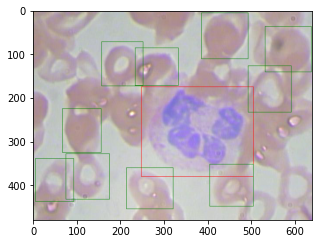

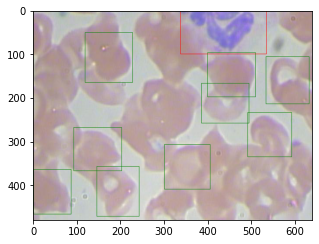

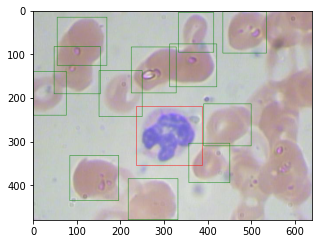

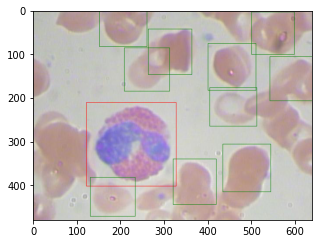

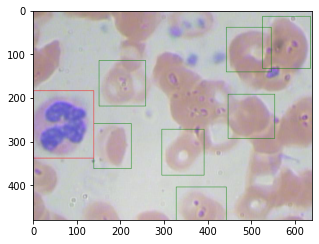

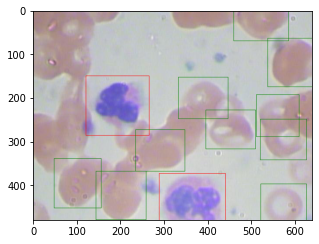

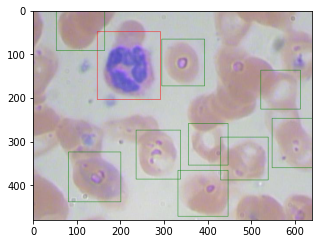

In [22]:
model.eval()
for i in test:
    p,t = ds[i]
    outputs = model([p])
    img = ds.get_image(i)
    draw = ImageDraw.Draw(img)
    classes = outputs[0]['labels'].cpu().numpy()
    scores = outputs[0]['scores'].detach().cpu().numpy()
    boxes = outputs[0]['boxes'].detach().cpu().numpy()

    for i,box in enumerate(boxes):
        if scores[i] > 0.5 :
            c = classes[i]
            c = c if c < 4 else 0
            cl = ['black','red','green','blue']
            draw.rectangle(xy=box.tolist(), outline=cl[c])
    plt.figure(figsize=(5, 5))
    plt.imshow(img)